In [1]:
!pip install pandas==2.2.2 numpy==1.26.4 tensorflow==2.17.1 matplotlib==3.8.0 imblearn

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib  # Import the main matplotlib module
from imblearn.over_sampling import SMOTE
import imblearn # Import the main imblearn module

print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("tensorflow version:", tf.__version__)
print("matplotlib version:", matplotlib.__version__)  # Access __version__ from matplotlib
print("imblearn version:", imblearn.__version__) # Access version for imblearn

pandas version: 2.2.2
numpy version: 1.26.4
tensorflow version: 2.17.1
matplotlib version: 3.8.0
imblearn version: 0.13.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Defining some useful global variables

Next you will define some global variables that will be used throughout the assignment. Feel free to reference them in the upcoming exercises:

- `EMBEDDING_DIM`: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 100.


- `MAX_LENGTH`: Maximum length of all sequences. Defaults to 32.

    
- `TRAINING_SPLIT`: Proportion of data used for training. Defaults to 0.9

- `NUM_BATCHES`: Number of batches. Defaults to 128



In [4]:
EMBEDDING_DIM = 100
MAX_LENGTH = 32
TRAINING_SPLIT = 0.9
NUM_BATCHES = 128
TEST_SPLIT_FROM_TRAIN = 0.05

## Import dataset and cleaning data

In [5]:
data_path = "/content/drive/MyDrive/Bangkit/Capstone/mental_health_conversations.csv"
df = pd.read_csv(data_path, header=None)
df.head()

,0,1,2
0,NaN,statement,status
1,0.0,oh my gosh,Anxiety
2,1.0,"trouble sleeping, confused mind, restless hear...",Anxiety
3,2.0,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
4,3.0,I've shifted my focus to something else but I'...,Anxiety


In [6]:
df = df.drop(index=0)

# Reset index if needed
df.reset_index(drop=True, inplace=True)

df.head()

,0,1,2
0,0.0,oh my gosh,Anxiety
1,1.0,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2.0,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3.0,I've shifted my focus to something else but I'...,Anxiety
4,4.0,"I'm restless and restless, it's been a month n...",Anxiety


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       53043 non-null  float64
 1   1       52681 non-null  object 
 2   2       53043 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.2+ MB


In [8]:
df.dropna(inplace = True)
df.isna().sum()

,0
0,0
1,0
2,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       52681 non-null  float64
 1   1       52681 non-null  object 
 2   2       52681 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.6+ MB


In [10]:
statuses = df[2].unique()
print(statuses)
print(len(statuses))

['Anxiety' 'Normal' 'Depression' 'Suicidal' 'Stress' 'Bipolar'
 'Personality disorder']
7


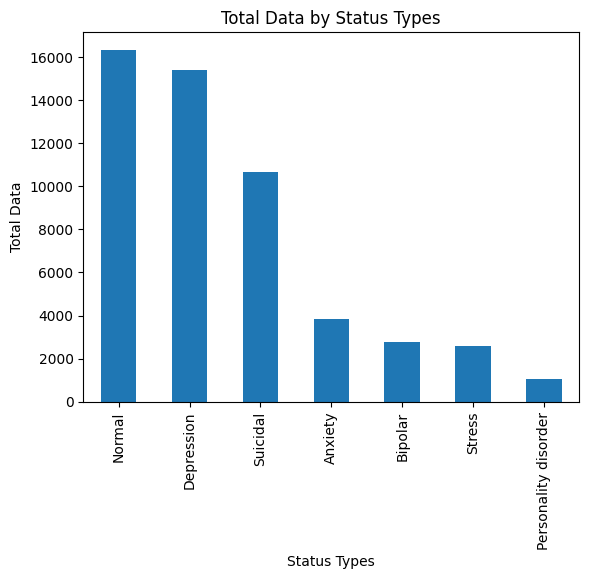

In [11]:
df[2].value_counts().plot(kind='bar')
plt.xlabel("Status Types")
plt.ylabel("Total Data")
plt.title("Total Data by Status Types")
plt.show()

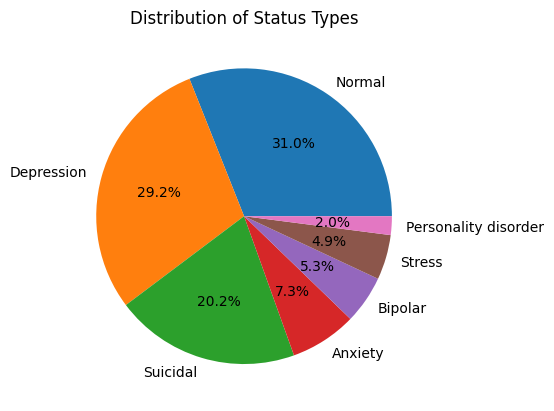

In [12]:
# Assuming df is already loaded as in the provided code
df[2].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Distribution of Status Types")
plt.ylabel("")  # Remove the y-axis label
plt.show()

In [13]:
# Standardize labels so they have
# 'Anxiety'              => 0
# 'Normal'               => 1
# 'Depression'           => 2
# 'Suicidal'             => 3
# 'Stress'               => 4
# 'Bipolar'              => 5
# 'Personality disorder' => 6
status_mapping = {
    'Anxiety': 0,
    'Normal': 1,
    'Depression': 2,
    'Suicidal': 3,
    'Stress': 4,
    'Bipolar': 5,
    'Personality disorder': 6
}
labels = df[2].apply(lambda x: status_mapping.get(x, -1)).to_numpy()  # Default to -1 if the value is not in the mapping

# Since the original dataset does not provide headers you need to index the columns by their index
sentences = df[1].to_numpy()

print(sentences[:5])
print(labels[:5])


['oh my gosh'
 'trouble sleeping, confused mind, restless heart. All out of tune'
 'All wrong, back off dear, forward doubt. Stay in a restless and restless place'
 "I've shifted my focus to something else but I'm still worried"
 "I'm restless and restless, it's been a month now, boy. What do you mean?"]
[0 0 0 0 0]


In [14]:
# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))

# Get the first 5 elements of the dataset
examples = list(dataset.take(5))

print(f"dataset contains {len(dataset)} examples\n")

print(f"Text of second example look like this: {examples[1][0].numpy().decode('utf-8')}\n")
print(f"Labels of first 5 examples look like this: {[x[1].numpy() for x in examples]}")

dataset contains 52681 examples

Text of second example look like this: trouble sleeping, confused mind, restless heart. All out of tune

Labels of first 5 examples look like this: [0, 0, 0, 0, 0]


In [15]:
def train_val_test_datasets(dataset, batch_size):
    dataset_size = len(dataset)

    dataset = dataset.shuffle(buffer_size=dataset_size, seed=42)

    # Compute sizes for each split
    train_size = int(dataset_size * TRAINING_SPLIT)
    val_size = dataset_size - train_size
    test_size = int(train_size * TEST_SPLIT_FROM_TRAIN)
    adjusted_train_size = train_size - test_size

    # Split the dataset
    train_dataset = dataset.take(adjusted_train_size)  # Remaining training data
    test_dataset = dataset.skip(adjusted_train_size).take(test_size)  # Test data
    val_dataset = dataset.skip(adjusted_train_size + test_size)  # Validation data

    # Batch the datasets
    train_dataset = train_dataset.batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)

    return train_dataset, val_dataset, test_dataset

In [16]:
train_dataset, val_dataset, test_dataset = train_val_test_datasets(dataset, NUM_BATCHES)

print(f"There are {len(train_dataset)} batches for a total of {NUM_BATCHES*len(train_dataset)} elements for training.\n")
print(f"There are {len(val_dataset)} batches for a total of {NUM_BATCHES*len(val_dataset)} elements for validation.\n")
print(f"There are {len(test_dataset)} batches for a total of {NUM_BATCHES*len(test_dataset)} elements for test.\n")

There are 352 batches for a total of 45056 elements for training.

There are 42 batches for a total of 5376 elements for validation.

There are 19 batches for a total of 2432 elements for test.



In [17]:
print(f"There are {len(dataset)} batches for a total of {NUM_BATCHES*len(dataset)} elements for training.\n")

There are 52681 batches for a total of 6743168 elements for training.



In [18]:
def fit_vectorizer(dataset):
  vectorizer = tf.keras.layers.TextVectorization(
      standardize='lower_and_strip_punctuation',
      output_mode='int',
      output_sequence_length=MAX_LENGTH
  )

  vectorizer.adapt(dataset)

  return vectorizer

In [19]:
text_only_dataset = train_dataset.map(lambda text, label: text)

vectorizer = fit_vectorizer(text_only_dataset)

vocab_size = vectorizer.vocabulary_size()

print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 73830 words



In [20]:
train_dataset_vectorized = train_dataset.map(lambda text, label: (vectorizer(text), label))
val_dataset_vectorized = val_dataset.map(lambda text, label: (vectorizer(text), label))

In [21]:
glove_file = '/content/drive/MyDrive/Bangkit/Capstone/Files/tf/data/glove.6B.100d.txt'

glove_embeddings = {}

with open(glove_file) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coefs

In [22]:
test_word = 'dog'

test_vector = glove_embeddings[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word dog looks like this:

[ 0.30817    0.30938    0.52803   -0.92543   -0.73671    0.63475
  0.44197    0.10262   -0.09142   -0.56607   -0.5327     0.2013
  0.7704    -0.13983    0.13727    1.1128     0.89301   -0.17869
 -0.0019722  0.57289    0.59479    0.50428   -0.28991   -1.3491
  0.42756    1.2748    -1.1613    -0.41084    0.042804   0.54866
  0.18897    0.3759     0.58035    0.66975    0.81156    0.93864
 -0.51005   -0.070079   0.82819   -0.35346    0.21086   -0.24412
 -0.16554   -0.78358   -0.48482    0.38968   -0.86356   -0.016391
  0.31984   -0.49246   -0.069363   0.018869  -0.098286   1.3126
 -0.12116   -1.2399    -0.091429   0.35294    0.64645    0.089642
  0.70294    1.1244     0.38639    0.52084    0.98787    0.79952
 -0.34625    0.14095    0.80167    0.20987   -0.86007   -0.15308
  0.074523   0.40816    0.019208   0.51587   -0.34428   -0.24525
 -0.77984    0.27425    0.22418    0.20164    0.017431  -0.014697
 -1.0235    -0.39695   -0.0056188  0.3

In [23]:
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (100,)


In [24]:
word_index = {x:i for i, x in enumerate(vectorizer.get_vocabulary())}

print(f"The word dog is encoded as: {word_index['dog']}")

The word dog is encoded as: 690


In [25]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, index in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [26]:
test_word = 'dog'

test_word_id = word_index[test_word]

test_vector_dog = glove_embeddings[test_word]

test_embedding_dog = embedding_matrix[test_word_id]

both_equal = np.allclose(test_vector_dog, test_embedding_dog)

print(f"word: {test_word}, index: {test_word_id}\n\nEmbedding is equal to column {test_word_id} in the embeddings_matrix: {both_equal}")

word: dog, index: 690

Embedding is equal to column 690 in the embeddings_matrix: True


In [104]:
def create_model(vocab_size, pretrained_embeddings):
  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(MAX_LENGTH,)),

      tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=pretrained_embeddings.shape[1]),

      tf.keras.layers.LSTM(units=64, return_sequences=True),

      tf.keras.layers.Dropout(0.5),

      tf.keras.layers.GlobalMaxPooling1D(),

      tf.keras.layers.Dense(units=64, activation='relu'),
      tf.keras.layers.Dense(units=7, activation='softmax')
  ])

  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
  )

  return model

In [105]:
model = create_model(vocab_size, embedding_matrix)

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 32, 100)             │       7,383,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32, 64)              │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_5               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,429,855 (28.34 MB)

 Trainable params: 7,429,855 (28.34 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
# Take an example batch of data
example_batch = train_dataset_vectorized.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (128, 7)


In [107]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='max',
    baseline=0.99,
    restore_best_weights=True
)

In [108]:
history = model.fit(
    train_dataset_vectorized,
    validation_data=val_dataset_vectorized,
    epochs=20,
    # callbacks=[early_stopping]
)

Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 123s 12ms/step - accuracy: 0.5529 - loss: 1.2109 - val_accuracy: 0.7571 - val_loss: 0.8497
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7443 - loss: 0.6493 - val_accuracy: 0.8041 - val_loss: 0.7291
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7999 - loss: 0.5202 - val_accuracy: 0.8594 - val_loss: 0.5835
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8436 - loss: 0.4165 - val_accuracy: 0.8785 - val_loss: 0.4869
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8695 - loss: 0.3474 - val_accuracy: 0.9021 - val_loss: 0.4286
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8848 - loss: 0.3077 - val_accuracy: 0.9188 - val_loss: 0.3457
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9042 - loss: 0.2586 - val_accuracy: 0.9228 - val_loss: 0.3208
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9158 - loss: 0.2252 - val_ac

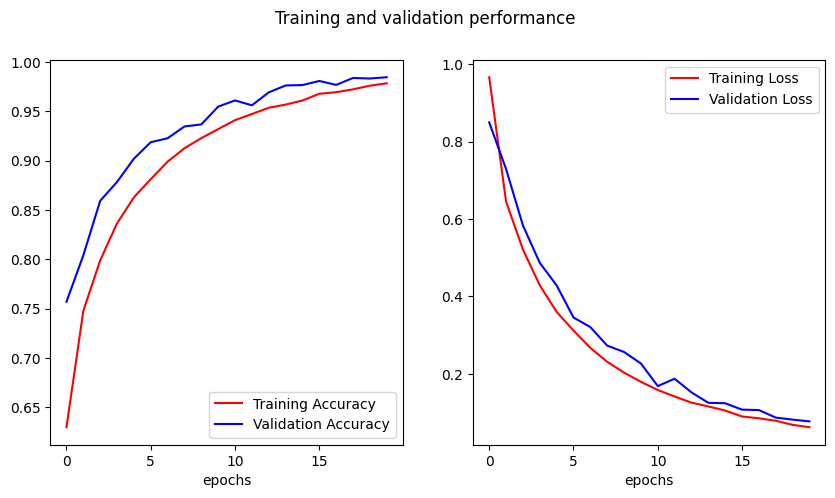

In [133]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation performance')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

In [134]:
embedding = model.layers[0]

with open('./smote_metadata.tsv', "w") as f:
    for word in vectorizer.get_vocabulary():
        f.write("{}\n".format(word))
weights = tf.Variable(embedding.get_weights()[0][1:])

with open('./smote_weights.tsv', 'w') as f:
    for w in weights:
        f.write('\t'.join([str(x) for x in w.numpy()]) + "\n")

## Evaluate Model

In [135]:
# Custom F1-score metric
def f1_score(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)  # Ensure y_true is of integer type

    # Calculate TP, FP, and FN using confusion matrix
    cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=7)  # Assuming 7 classes
    tp = tf.linalg.diag_part(cm)  # True positives are diagonal elements
    fp = tf.reduce_sum(cm, axis=0) - tp  # False positives
    fn = tf.reduce_sum(cm, axis=1) - tp  # False negatives

    # Calculate precision and recall
    # Cast tp, fp, and fn to float32 to match epsilon's type
    precision = tf.cast(tp, tf.float32) / (tf.cast(tp, tf.float32) + tf.cast(fp, tf.float32) + tf.keras.backend.epsilon())
    recall = tf.cast(tp, tf.float32) / (tf.cast(tp, tf.float32) + tf.cast(fn, tf.float32) + tf.keras.backend.epsilon())

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    # Return macro-averaged F1 score
    return tf.reduce_mean(f1)

In [136]:
export_model = tf.keras.Sequential([
    vectorizer,
    model,
    tf.keras.layers.Activation('softmax')
])

export_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

metrics = export_model.evaluate(test_dataset, return_dict=True)
print(metrics)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9864 - loss: 0.0000e+00
{'accuracy': 0.9839662313461304, 'loss': 0.0}


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


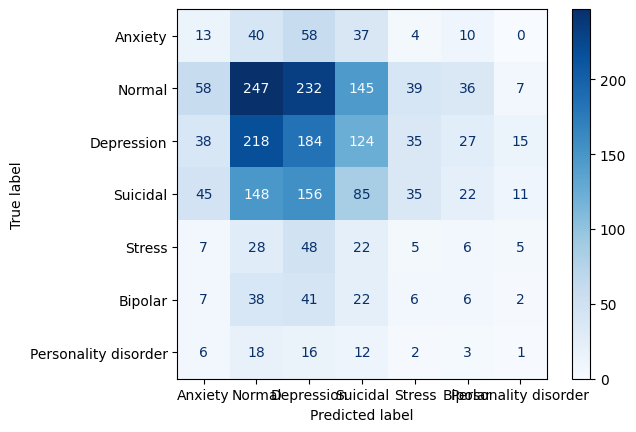

In [137]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Extract true labels (y_true) from test_dataset
y_true = []
for _, label_batch in test_dataset:  # Iterate over the batches in test_dataset
    y_true.extend(label_batch.numpy())  # Append labels to the list
y_true = np.array(y_true)  # Convert the list to a NumPy array

# Generate predictions
y_pred = np.argmax(export_model.predict(test_dataset), axis=1)

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)  # Use y_true instead of y_test

# Define class labels (assuming you have 7 classes)
class_names = ['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar', 'Personality disorder']

# Visualize the confusion matrix, using class_names as display_labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  # Changed to class_names
disp.plot(cmap='Blues')

In [138]:
from sklearn.metrics import classification_report

# Generate predictions using the export_model (which includes the vectorizer)
y_pred = np.argmax(export_model.predict(test_dataset), axis=1)

# Extract true labels (y_true) from test_dataset
y_true = []
for _, label_batch in test_dataset:
    y_true.extend(label_batch.numpy())
y_true = np.array(y_true)

# Print a classification report
print(classification_report(y_true, y_pred, target_names=class_names))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                      precision    recall  f1-score   support

             Anxiety       0.06      0.06      0.06       163
              Normal       0.30      0.30      0.30       754
          Depression       0.28      0.29      0.29       700
            Suicidal       0.19      0.18      0.19       471
              Stress       0.05      0.05      0.05       116
             Bipolar       0.03      0.03      0.03       122
Personality disorder       0.00      0.00      0.00        44

            accuracy                           0.23      2370
           macro avg       0.13      0.13      0.13      2370
        weighted avg       0.23      0.23      0.23      2370



In [139]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np  # Import numpy

# Instead of extracting X_test, directly use the vectorized test dataset:
y_true = []
y_pred_prob = []

for text_batch, label_batch in test_dataset:
    # Get the vectorized text for prediction
    vectorized_text = vectorizer(text_batch)

    # Get probabilities for each class
    batch_pred_prob = model.predict(vectorized_text)  # Predict on vectorized text
    y_pred_prob.extend(batch_pred_prob)  # Append predictions

    y_true.extend(label_batch.numpy())

y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)  # Convert predictions to NumPy array


# Binarize the labels
y_test_binarized = label_binarize(y_true, classes=np.unique(y_true))


# Calculate macro-average AUC
auc = roc_auc_score(y_test_binarized, y_pred_prob, average="macro", multi_class="ovr")
print(f"Macro AUC: {auc}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Macro AUC: 0.999735945788071


In [140]:
# Class-wise accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Print or visualize
for i, acc in enumerate(class_accuracies):
    print(f"Accuracy for class {class_names[i]}: {acc:.2f}")

Accuracy for class Anxiety: 0.08
Accuracy for class Normal: 0.32
Accuracy for class Depression: 0.29
Accuracy for class Suicidal: 0.17
Accuracy for class Stress: 0.04
Accuracy for class Bipolar: 0.05
Accuracy for class Personality disorder: 0.02


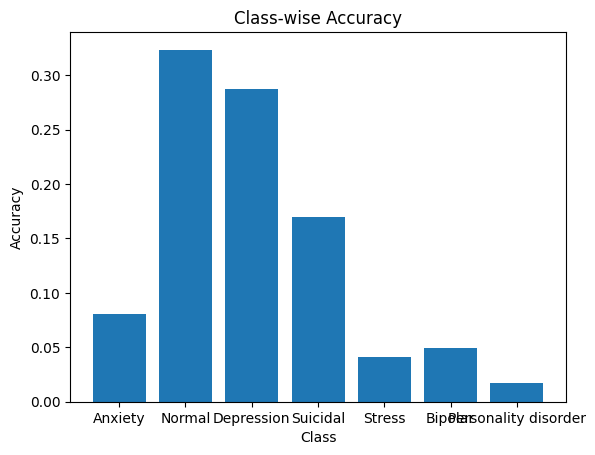

In [141]:
import matplotlib.pyplot as plt

plt.bar(class_names, class_accuracies)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.show()

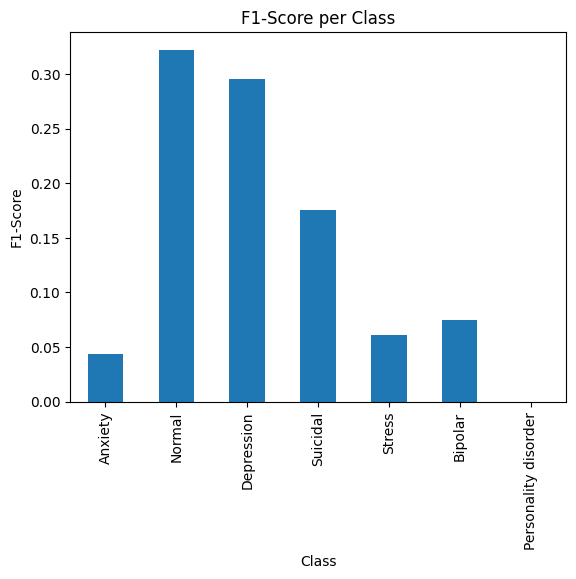

In [142]:
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
df = pd.DataFrame(report).transpose()

# Plot F1-scores
df['f1-score'][:-3].plot(kind='bar', title='F1-Score per Class', ylabel='F1-Score', xlabel='Class')
plt.show()

## Save Model

In [143]:
metrics = export_model.evaluate(test_dataset, return_dict=True)
print(metrics)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9793 - loss: 0.0000e+00
{'accuracy': 0.9831223487854004, 'loss': 0.0}


In [144]:
export_model.save('imbalance_mental_health.keras')

## Load Model

In [145]:
laoded_model_w_vectorizer = tf.keras.models.load_model('imbalance_mental_health.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [146]:
new_texts = [
    "Going on a long vacation, 21 days, with a big time change. Time change and taking meds question. So I have all my meds filled and enough for the trip + afterwards. I typically take my meds at 8pm every night and right before bed. I’m very good at taking my meds on time I really don’t miss them, so I just want to be safe when it comes to being in a different time zone. Do I take them at the same in the other country, or do I take them at the same time I would while there? And any tips from you guys about traveling. I’m a bit nervous to step out of my really good routine and sleep schedule and be traveling to multiple countries. My therapist/prescribing nurse have confidence in me and support this trip too.	",
    "I'm sure that today, the one who came to the school hall, Mr. Madam, is proud, mmf, isn't your son, hey, or his brain is thin...",
    "Panic Attacks Hi, I've been having very bad anxiety attacks lately. I've been taking valium and it's helped but doesn't eliminate it. I've never had it sooooo bad. I also take olanzapine. I'm in the gym trying to push it away but I want to run home and take a valium. However, I only have a few tablets left. I'm really struggling on what to do. Anyone else feel the same or have been in a similar place?",
    "i feel happy",
    "i feel very happy",
    # "I am feeling great today!",
    # "I am so stressed out",
    # "It just felt like a storm, rumbling, boisterous, restless and quite stifling.",
    # "It's been a long time since I've been here, I'm suddenly restless + crazy chest pain",
]
new_texts_tensor = tf.convert_to_tensor(new_texts)

predictions = laoded_model_w_vectorizer.predict(new_texts_tensor)
print(predictions)

class_labels = ['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar', 'Personality disorder']

for pred in predictions:
  predicted_class = np.argmax(pred, axis=-1)
  predicted_label = class_labels[predicted_class]

  print(f"Predicted class: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
[[0.11827095 0.11798861 0.13207173 0.12260176 0.1179205  0.27323967
  0.11790676]
 [0.11473355 0.3114957  0.11473104 0.11473011 0.11485031 0.11473063
  0.11472863]
 [0.30948818 0.11537535 0.11492185 0.11490867 0.11519598 0.11518937
  0.11492062]
 [0.12172821 0.26649112 0.13386142 0.12200542 0.11853224 0.11893993
  0.11844169]
 [0.11757617 0.29583967 0.12036467 0.11755376 0.11616022 0.11637367
  0.11613184]]
Predicted class: Bipolar
Predicted class: Normal
Predicted class: Anxiety
Predicted class: Normal
Predicted class: Normal
